# Margin Loans Risk Evaluation

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from yahoo_fin import options
from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import sys
plt.style.use('default')
pio.templates.default = "seaborn"

sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/functions')
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/calibration')

from BSpricer import BS_Pricer
from MERTONpricer import Merton_pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

np.random.seed(27)

### Get Option Data

In [3]:
symbol = 'AAPL'  # AAPL, TSLA, NVDA
stock_data = si.get_data(symbol, start_date='1/15/2016', end_date='1/20/2016')
print(stock_data)
last_price = stock_data['close'].iloc[-1]
print(f'\n{symbol}\'s last_price: ', last_price)

                 open     high     low      close   adjclose     volume ticker
2016-01-15  24.049999  24.4275  23.840  24.282499  22.135746  319335600   AAPL
2016-01-19  24.602501  24.6625  23.875  24.165001  22.028633  212350800   AAPL

AAPL's last_price:  24.165000915527344


#### Simulate Monte Carlo Paths with calibrated parameters

In [4]:
# get parameters from OTKO calibration
%store -r otko_mert_params_aapl
%store -r otko_kou_params_aapl
%store -r otko_vg_params_aapl

# get params from mixed calibration: calls+otko
%store -r calls_otko_mert_params_aapl
%store -r calls_otko_kou_params_aapl
%store -r calls_otko_vg_params_aapl

# get params from mixed calibration: puts+otko
%store -r puts_otko_mert_params_aapl
%store -r puts_otko_kou_params_aapl
%store -r puts_otko_vg_params_aapl


### Monte Carlo simulations

In [5]:
days = 252
paths = 100
T = 1
r = 0.03
q = 0

#### Merton Jump Diffusion paths

In [6]:
# OTKO_PARAMS 
sigma, lambd, m, v = otko_mert_params_aapl
Mert1 = Merton_pricer(last_price, None, T, r, q, sigma, lambd, m, v, None)
Smert1 = Mert1.MertonPath(days, paths)

# CALLS+OTKO PARAMS
sigma, lambd, m, v = calls_otko_mert_params_aapl
Mert2 = Merton_pricer(last_price, None, T, r, q, sigma, lambd, m, v, None)
Smert2 = Mert2.MertonPath(days, paths)

# PUTS + OTKO PARAMS
sigma, lambd, m, v = puts_otko_mert_params_aapl
Mert3 = Merton_pricer(last_price, None, T, r, q, sigma, lambd, m, v, None)
Smert3 = Mert3.MertonPath(days, paths)

CALIBRATED PARAMETERS	 [σ		λ		m		v]
1. OTKO DAILY CLIQUETS:	 [0.22, 3.0223, 0.0346, 0.2274]
2. CALLS + OTKO:		 [0.1749, 1.2291, -0.1322, 0.166]
3. PUTS + OTKO:			 [0.3175, 1.126, -0.1533, 0.1681]


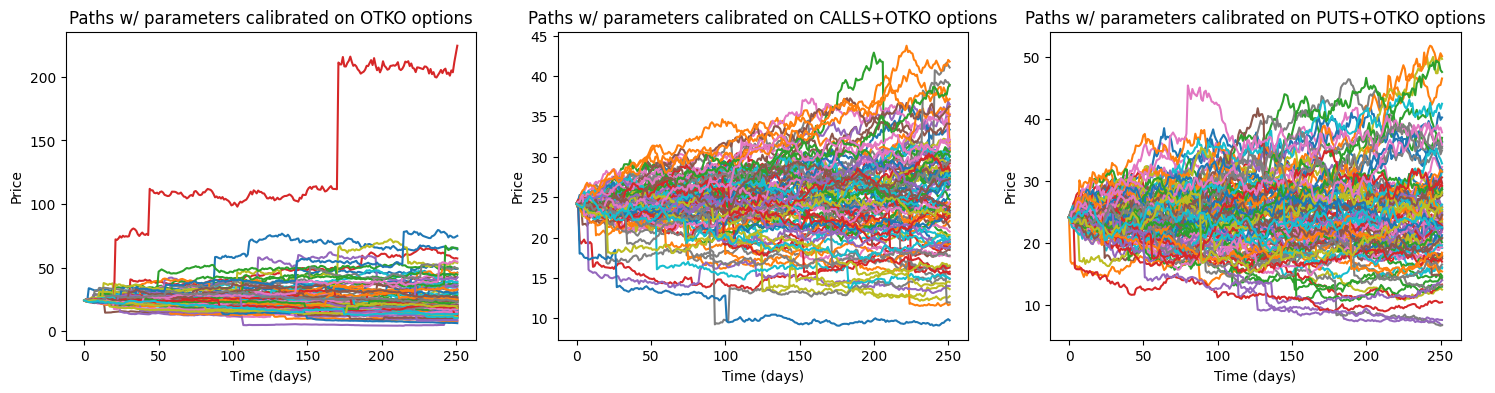

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [7]:
# SHOW PARAMETERS
print(f'CALIBRATED PARAMETERS\t [σ\t\tλ\t\tm\t\tv]')
print(f'1. OTKO DAILY CLIQUETS:\t {otko_mert_params_aapl}')
print(f'2. CALLS + OTKO:\t\t {calls_otko_mert_params_aapl}')
print(f'3. PUTS + OTKO:\t\t\t {puts_otko_mert_params_aapl}')

options = ['OTKO', 'CALLS+OTKO', 'PUTS+OTKO']

fig1, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
for i in range(3): 
    model_ = f'Mert{i+1}'
    paths_ = f'Smert{i+1}'
    model = locals()[model_]
    paths_ = locals()[paths_]
    model.plotMertonPath(paths_, symbol, ax=axes[i])
    axes[i].set_title(f'Paths w/ parameters calibrated on {options[i]} options')

plt.tight_layout()
plt.show()

#### Kou Jump Diffusion paths

In [8]:
# SOLE OTKO
sigma, lambd, p, eta1, eta2 = otko_kou_params_aapl
Kou1 = Kou_pricer(last_price, None, T, r, sigma, lambd,p, eta1, eta2, None)
Skou1 = Kou1.KouPath(days, paths)

# MIXED CALLS+OTKO
sigma, lambd, p, eta1, eta2 = calls_otko_kou_params_aapl
Kou2 = Kou_pricer(last_price, None, T, r, sigma, lambd,p, eta1, eta2, None)
Skou2 = Kou2.KouPath(days, paths)

# MIXED CALLS+OTKO
sigma, lambd, p, eta1, eta2 = puts_otko_kou_params_aapl
Kou3 = Kou_pricer(last_price, None, T, r, sigma, lambd,p, eta1, eta2, None)
Skou3 = Kou3.KouPath(days, paths)

CALIBRATED PARAMETERS	 [σ		λ		p		η1		η2]]
1. OTKO DAILY CLIQUETS:	 [0.19, 3.3332, 0.1281, 8.4, 5.4527]
2. CALLS + OTKO:		 [0.0701, 1.9831, 0.3788, 7.6703, 5.9635]
3. PUTS + OTKO:			 [0.0296, 3.0525, 0.3867, 6.0147, 5.8484]


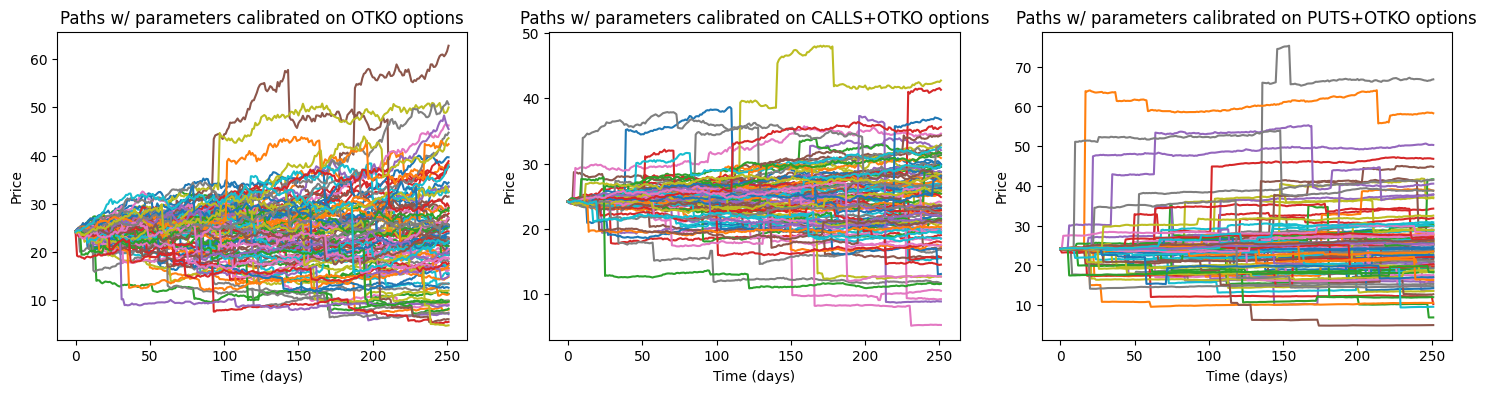

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [9]:
# SHOW PARAMETERS
print(f'CALIBRATED PARAMETERS\t [σ\t\tλ\t\tp\t\tη1\t\tη2]]')
print(f'1. OTKO DAILY CLIQUETS:\t {otko_kou_params_aapl}')
print(f'2. CALLS + OTKO:\t\t {calls_otko_kou_params_aapl}')
print(f'3. PUTS + OTKO:\t\t\t {puts_otko_kou_params_aapl}')

fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
for i in range(3): 
    model_ = f'Kou{i+1}'
    paths_ = f'Skou{i+1}'
    model = locals()[model_]
    paths_ = locals()[paths_]
    model.plotKouPath(paths_, symbol, ax=axes[i])
    axes[i].set_title(f'Paths w/ parameters calibrated on {options[i]} options')

plt.tight_layout()
plt.show()

#### Variance gamma model

In [10]:
# OTKO
sigm, theta, nu = otko_vg_params_aapl
VG1 = VG_pricer(last_price, None, T, r, q, sigm, theta, nu, None)
Svg1 = VG1.VarianceGammaPath1(days, paths)

# CALLS+OTKO
sigm, theta, nu = calls_otko_vg_params_aapl
VG2 = VG_pricer(last_price, None, T, r, q, sigm, theta, nu, None)
Svg2 = VG2.VarianceGammaPath1(days, paths)

# PUTS+OTKO
sigm, theta, nu = puts_otko_vg_params_aapl
VG3 = VG_pricer(last_price, None, T, r, q, sigm, theta, nu, None)
Svg3 = VG3.VarianceGammaPath1(days, paths)

CALIBRATED PARAMETERS	 [σ		θ		v]
3. OTKO DAILY CLIQUETS:	 [0.4737, 0.1965, 0.3018]
4. CALLS + OTKO:		 [0.2938, -0.0328, 1.7689]
5. PUTS + OTKO:			 [0.3134, 0.0583, 1.7865]


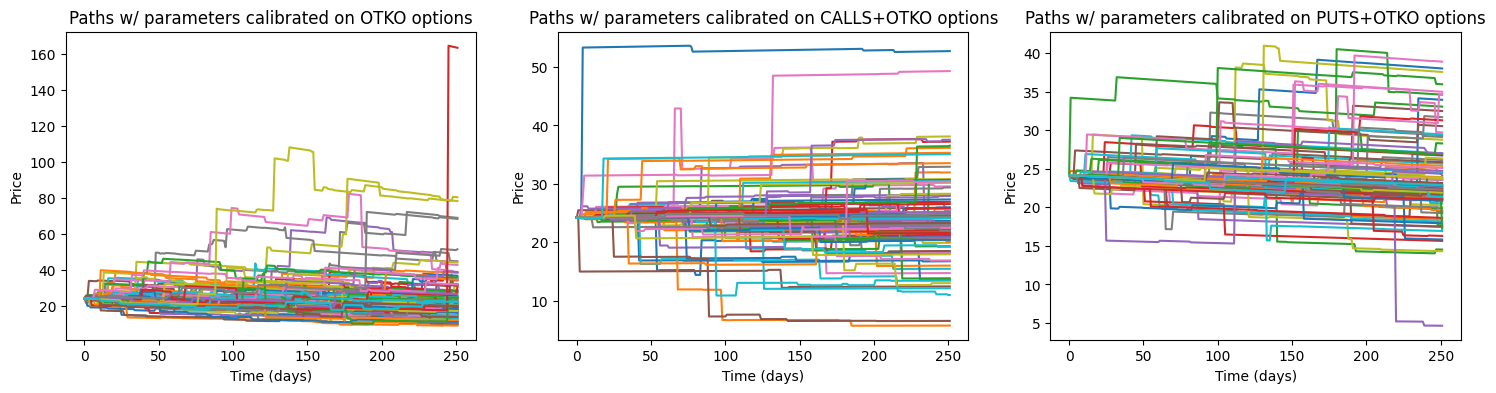

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [11]:
# SHOW PARAMETERS
print(f'CALIBRATED PARAMETERS\t [σ\t\tθ\t\tv]')
print(f'3. OTKO DAILY CLIQUETS:\t {otko_vg_params_aapl}')
print(f'4. CALLS + OTKO:\t\t {calls_otko_vg_params_aapl}')
print(f'5. PUTS + OTKO:\t\t\t {puts_otko_vg_params_aapl}')

fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
for i in range(3): 
    model_ = f'VG{i+1}'
    paths_ = f'Svg{i+1}'
    model = locals()[model_]
    paths_ = locals()[paths_]
    model.plotVGPath(paths_, symbol, method='Time changed BM', ax=axes[i])
    axes[i].set_title(f'Paths w/ parameters calibrated on {options[i]} options')

plt.tight_layout()
plt.show()

## Margin Loan Requirements
Checks how many paths are unable to end above the loan amount. 

#### Steps through margin loans evaluation (no margin calls admitted)
1. For each simulated path $i = 1,...,N$ evaluate the final price $S_i (T)$ after the time period $T$
2. Compute $finalvalue = S_i(T) \cdot numshares$ 
3. If $finalvalue \geq loanvalue$ then 
    $ loss_i = 0 $
   Elseif $finalvalue < loanvalue$ then 
    $ loss_i = loanvalue - S_i(T)$
   
3. Compute $averageloss = \frac{1}{N} \sum_{i=1}^{N} loss_i$
4. Compute $loanprice = \exp^{-rT} \cdot averageloss $

In [12]:
### PAYOFF. NO MARGIN CALLS REQUIRED ###
def margin_loan_price0(Spaths, loan): 
    loss = np.zeros(paths)
    
    for S_T in Spaths[-1, :]:  # takes the final values of each path
        final_value = num_of_shares_at_S0 * S_T
        if final_value >= loan: 
            loss.append(0)
        else: 
            loss.append(loan -final_value)
    
    avg_loss = np.mean(loss)
    return np.exp(-r*T)*avg_loss

#### Steps through margin loans evaluation (with margin calls allowed)
Let's say there's a limit to the number of shares that our company can give as collateral. Let's say this limit is the ***2x  numshares*** of the ones it gave when the contract started. Then, we have to perform a "dynamic" evaluation. We save for each path the number of margin calls that are required. Clearly, the cumulative amount of shares added during $T$ cannot exceed the saturation limit, i.e. ***2x  numshares*** 
Additionally, we set a trigger of 10%. This means that **if** the stock price becomes such that $$S(t) * numshares \leq (1-0.1) \cdot loan$$ there's a **margin call** and the num of shares as collateral has to be reintegrated in order to re-establish the **loan-to-value** ratio. 
$$( num of shares at S0 + added num of shares) * S(t) = collateral = ltv * loan$$  

In [13]:
### PAYOFF. MARGIN CALLS ALLOWED ###
def margin_loan_price1(Spaths, loan): 
    num_shares_required = [num_of_shares_at_S0] * paths         # each cell stores the required shares for each path
    num_margin_calls = np.zeros(paths)                  # each cell will contain the number of times a margin call is required
    flag = ['green'] * paths                    # this is needed to decide if the margin call can be satisfied or not
    loss = np.zeros(paths)
    
    for path in range(paths):   # takes ALL THE PATHS day by day; days are on the rows so each column is a path
        for day in range(days-1): 
            price = Spaths[day][path]
            if flag[path] == 'green':           # there's still room for other shares. reintegration is possible 
                if (price * num_shares_required[path]) <= ((1-trigger) * loan):
                    num_margin_calls[path]+=1       # margin call required  
                    ## Reintegration  ##
                    shares_needed = collateral / price          # computing this time by time 
                    if shares_needed >= max_shares: 
                        num_shares_required[path] = max_shares; flag[path] = 'red'
                    else: 
                        num_shares_required[path] = round(shares_needed,2)       #still room for other shares 
                else: 
                    ## No reintegration needed ##
                    continue
            # else if flag is red, no more shares can be given to the bank.     
    
    # PROFIT & LOSS
    for index in range(paths):          # let's consider the final value: 
        S_T = Spaths[-1, index]            # STOCK's final price of each path
        final_value = S_T * num_shares_required[index]
        gain_loss = final_value - loan      # if positive, it's a gain, else, it's a loss
    avg_gain_loss = np.mean(gain_loss)
    
    # ONLY POTENTIAL LOSSES 
    for index in range(paths):          # let's consider the final value: 
        S_T = Spaths[-1, index]            # STOCK's final price of each path
        final_value = S_T * num_shares_required[index]
        if final_value >= loan: 
            loss[index] = 0 
        else: 
            loss[index] = loan-final_value
    avg_loss = np.mean(loss)
    
    print('Average margin calls: ', np.mean(num_margin_calls))
    print('Probability of a margin call: ', np.sum(num_margin_calls)/(days*paths))
    print('Average loss: ', avg_loss)
    print('Average profit & loss: ', avg_gain_loss)
    #print('Num of shares required: \n', num_shares_required)
    print('Average num of shares required: ', np.mean(num_shares_required))
    return avg_loss

#### MARGIN LOANS COMPUTATIONS

In [14]:
loan = 1000000          # 1 million
loan_to_value = 1.2
collateral = loan_to_value * loan
num_of_shares_at_S0 = round(collateral / last_price,2)
max_shares = num_of_shares_at_S0 * 2
trigger = 0.1       # -10%  
print(f'> DATE: {datetime.utcnow().strftime("%Y-%m-%d")}')
print(f'> TIME PERIOD: {T} years')
print(f'> LOAN: {loan}€ ')
print(f'> COLLATERAL: {collateral}€ ')
print(f'> {symbol} CLOSING PRICE: {round(last_price,2)}')
print(f'> INITIAL NUM OF SHARES AS COLLATERAL: {num_of_shares_at_S0}')
print(f'> MAX COLLATERAL SHARES:  {max_shares}')

> DATE: 2023-09-08
> TIME PERIOD: 1 years
> LOAN: 1000000€ 
> COLLATERAL: 1200000.0€ 
> AAPL CLOSING PRICE: 24.17
> INITIAL NUM OF SHARES AS COLLATERAL: 49658.6
> MAX COLLATERAL SHARES:  99317.2


Let's suppose to use the parameters calibrated on **OTKO** options only. Let's see what happens to each of the three models simulated: **MJD**, **KJD**, **VG**. 

#### Merton Jump Diffusion model 

In [15]:
# set of paths number 1. Parameters simulated on OTKO options only
#print(Smert1[-1])
loss_merton1 = margin_loan_price1(Smert1, loan)
print(f'LOAN of {loan}€, according to the Merton model (set #1)\nLOSS = {loss_merton1}')

Average margin calls:  0.74
Probability of a margin call:  0.0029365079365079364
Average loss:  13905.74657566029
Average profit & loss:  -55911.78027525148
Average num of shares required:  65253.31179999998
LOAN of 1000000€, according to the Merton model (set #1)
LOSS = 13905.74657566029


#### Kou Jump Diffusion model 

In [16]:
# set of paths number 1. Parameters simulated on OTKO options only
#print(Skou1[-1])
loss_kou1 = margin_loan_price1(Skou1, loan)
print(f'LOAN of {loan}€, loan-to-value {loan_to_value}.\nAccording to the Kou model (set #1) the LOSS is {loss_kou1}')

Average margin calls:  0.61
Probability of a margin call:  0.002420634920634921
Average loss:  27551.15229819083
Average profit & loss:  686202.3926819663
Average num of shares required:  64751.03129999999
LOAN of 1000000€, loan-to-value 1.2.
According to the Kou model (set #1) the LOSS is 27551.15229819083


#### Variance Gamma model

In [17]:
# set of paths number 1. Parameters simulated on OTKO options only
#print(Svg1[-1])
loss_vg1 = margin_loan_price1(Svg1, loan)
print(f'LOAN of {loan}€, loan-to-value {loan_to_value}.\nAccording to the Variance Gamma model (set #1) the LOSS is {loss_vg1}')

Average margin calls:  0.66
Probability of a margin call:  0.002619047619047619
Average loss:  6709.388216849738
Average profit & loss:  486886.6678359383
Average num of shares required:  64337.695999999974
LOAN of 1000000€, loan-to-value 1.2.
According to the Variance Gamma model (set #1) the LOSS is 6709.388216849738


Now, let's use parameters calibrated on the CALLS+OTKO option prices to see how different the outcome is. 

In [18]:
# Merton JD set #2: CALLS + OTKO
#print(Smert2[-1])
loss_merton2 = margin_loan_price1(Smert2, loan)
print(f'LOAN of {loan}€, according to the Merton model (set #2)\nLOSS = {loss_merton2}')

Average margin calls:  0.28
Probability of a margin call:  0.0011111111111111111
Average loss:  3092.8239571374015
Average profit & loss:  330087.08743960294
Average num of shares required:  55662.087099999975
LOAN of 1000000€, according to the Merton model (set #2)
LOSS = 3092.8239571374015


In [19]:
# Kou Jump Diffusion set #2: CALLS + OTKO
#print(Skou2[-1])
loss_kou2 = margin_loan_price1(Skou2, loan)
print(f'LOAN of {loan}€, loan-to-value {loan_to_value}.\nAccording to the Kou model (set #2) the LOSS is {loss_kou2}')

Average margin calls:  0.25
Probability of a margin call:  0.000992063492063492
Average loss:  8531.274522723677
Average profit & loss:  -31229.172692116234
Average num of shares required:  56987.31099999998
LOAN of 1000000€, loan-to-value 1.2.
According to the Kou model (set #2) the LOSS is 8531.274522723677


In [20]:
# Variance Gamma set #2: CALLS + OTKO
#print(Svg2[-1])
loss_vg2 = margin_loan_price1(Svg2, loan)
print(f'LOAN of {loan}€, loan-to-value {loan_to_value}.\nAccording to the Variance Gamma model (set #2) the LOSS is {loss_vg2}')

Average margin calls:  0.21
Probability of a margin call:  0.0008333333333333334
Average loss:  10188.165855186415
Average profit & loss:  741642.1617228612
Average num of shares required:  55528.96049999997
LOAN of 1000000€, loan-to-value 1.2.
According to the Variance Gamma model (set #2) the LOSS is 10188.165855186415


And finally let's see what happens when parameters of the models are calibrated on set 3: PUTS and OTKO options

In [21]:
# Merton JD set #3: PUTS + OTKO
#print(Smert3[-1])
loss_merton3 = margin_loan_price1(Smert3, loan)
print(f'LOAN of {loan}€, according to the Merton model (set #3)\nLOSS = {loss_merton3}')

Average margin calls:  0.5
Probability of a margin call:  0.001984126984126984
Average loss:  9862.455003252282
Average profit & loss:  120890.76346334931
Average num of shares required:  60077.98469999998
LOAN of 1000000€, according to the Merton model (set #3)
LOSS = 9862.455003252282


In [22]:
# Kou Jump Diffusion set #3: PUTS + OTKO
#print(Skou3[-1])
loss_kou3 = margin_loan_price1(Skou3, loan)
print(f'LOAN of {loan}€, loan-to-value {loan_to_value}.\nAccording to the Kou model (set #3) the LOSS is {loss_kou3}')

Average margin calls:  0.38
Probability of a margin call:  0.001507936507936508
Average loss:  10503.948185490626
Average profit & loss:  532855.5364401317
Average num of shares required:  59758.60789999997
LOAN of 1000000€, loan-to-value 1.2.
According to the Kou model (set #3) the LOSS is 10503.948185490626


In [23]:
# Variance Gamma set #3: CALLS + OTKO
#print(Svg3[-1])
loss_vg3 = margin_loan_price1(Svg3, loan)
print(f'LOAN of {loan}€, loan-to-value {loan_to_value}.\nAccording to the Variance Gamma model (set #3) the LOSS is {loss_vg3}')

Average margin calls:  0.13
Probability of a margin call:  0.0005158730158730159
Average loss:  11049.815786985782
Average profit & loss:  135365.60261163185
Average num of shares required:  52810.14939999997
LOAN of 1000000€, loan-to-value 1.2.
According to the Variance Gamma model (set #3) the LOSS is 11049.815786985782


In [24]:
# TODO: bar plot of the average value of losses 
# TODO: loss distributions, quantile etc... 